<a href="https://colab.research.google.com/github/rohit-arunn/lung-cancer-prediction/blob/main/lung_cancer_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from xgboost import plot_importance


In [70]:
df = pd.read_csv("survey lung cancer.csv")

The below is a small glimpse of the datasheet used for this task. All are binary values except for a few.

In [71]:
df.head(10)

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO
5,F,75,1,2,1,1,2,2,2,2,1,2,2,1,1,YES
6,M,52,2,1,1,1,1,2,1,2,2,2,2,1,2,YES
7,F,51,2,2,2,2,1,2,2,1,1,1,2,2,1,YES
8,F,68,2,1,2,1,1,2,1,1,1,1,1,1,1,NO
9,M,53,2,2,2,2,2,1,2,1,2,1,1,2,2,YES


In [51]:
df.isnull().sum()



,0
GENDER,0
AGE,0
SMOKING,0
YELLOW_FINGERS,0
ANXIETY,0
PEER_PRESSURE,0
CHRONIC DISEASE,0
FATIGUE,0
ALLERGY,0
WHEEZING,0


In [52]:
print(f"Number of columns in the dataset: {df.shape[1]}")

Number of columns in the dataset: 16


In [53]:
# Separate target variable 'Level' from features
y = df["LUNG_CANCER"]

# Drop 'Level' and 'Patient Id' from features (X)
X = df.drop(["LUNG_CANCER"], axis=1)

# Apply one-hot encoding to the remaining features in X
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

XGBoost Accuracy: 0.9839
XGBoost F1 Score (weighted): 0.9812

Classification Report:
              precision    recall  f1-score   support

          NO       1.00      0.50      0.67         2
         YES       0.98      1.00      0.99        60

    accuracy                           0.98        62
   macro avg       0.99      0.75      0.83        62
weighted avg       0.98      0.98      0.98        62



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:30:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


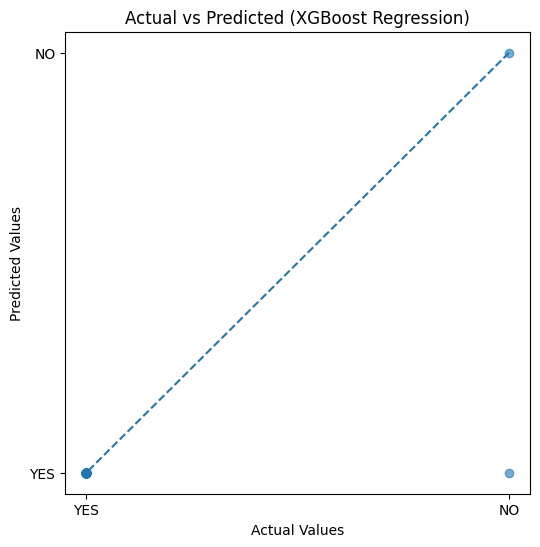

In [54]:
from sklearn.preprocessing import LabelEncoder

# XGBoost requires numerical labels for classification
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Initialize and train the XGBoost Classifier
xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), eval_metric='mlogloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train_scaled, y_train_encoded)

# Make predictions
xgb_pred_encoded = xgb_model.predict(X_test_scaled)

# Convert predictions back to original labels for evaluation
xgb_pred = le.inverse_transform(xgb_pred_encoded)

# Evaluate the model
xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred, average='weighted') # Use weighted for multi-class

print(f"XGBoost Accuracy: {xgb_acc:.4f}")
print(f"XGBoost F1 Score (weighted): {xgb_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred))


plt.figure(figsize=(6,6))
plt.scatter(y_test, xgb_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted (XGBoost Regression)")
plt.show()


<Figure size 800x600 with 0 Axes>

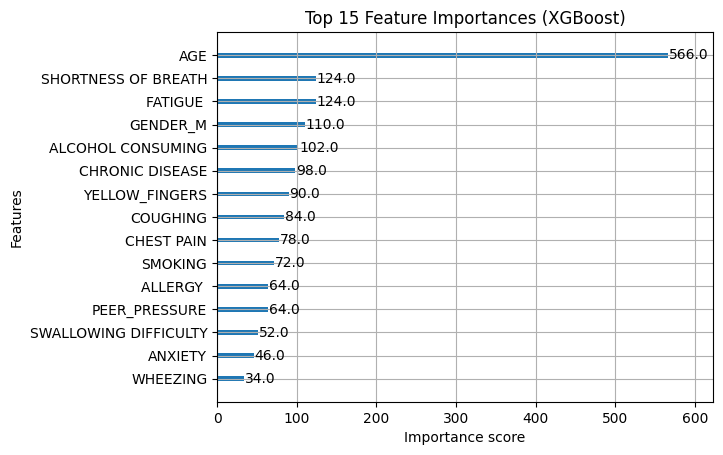

In [55]:
xgb_model.get_booster().feature_names = X_train.columns.tolist()

plt.figure(figsize=(8,6))
plot_importance(xgb_model, max_num_features=15)
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()

In [56]:
new_patient = [[
    1,  # GENDER
    75, # AGE
    1,  # SMOKING
    1,  # YELLOW_FINGERS
    0,  # ANXIETY
    1,  # PEER_PRESSURE
    0,  # CHRONIC DISEASE
    1,  # FATIGUE
    0,  # ALLERGY
    1,  # WHEEZING
    1,  # ALCOHOL CONSUMING
    1,  # COUGHING
    1,  # SHORTNESS OF BREATH
    0,  # SWALLOWING DIFFICULTY
    1   # CHEST PAIN
]]

prediction = xgb_model.predict(new_patient)
probability = xgb_model.predict_proba(new_patient)

print("Prediction:", "Lung Cancer" if prediction[0] == 1 else "No Lung Cancer")
print("Probability:", probability)


Prediction: Lung Cancer
Probability: [[0.00224305 0.997757  ]]


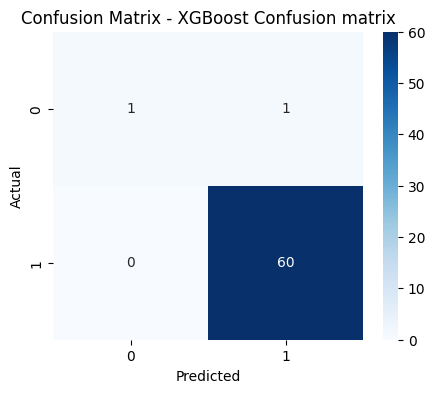

In [57]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

plot_confusion_matrix(y_test, xgb_pred, "XGBoost Confusion matrix")

In [67]:
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER


In [72]:
df['GENDER'] = df['GENDER'].replace({'M': 1, 'F': 0})
df['LUNG_CANCER'] = df['LUNG_CANCER'].replace({'YES': 1, 'NO': 0})

# Remove rows with missing target
df = df.dropna(subset=['LUNG_CANCER'])

# Split features and target
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

# Force numeric
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/tmp/ipython-input-1696637787.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['GENDER'] = df['GENDER'].replace({'M': 1, 'F': 0})
/tmp/ipython-input-1696637787.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['LUNG_CANCER'] = df['LUNG_CANCER'].replace({'YES': 1, 'NO': 0})


In [73]:
class LungCancerDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [74]:


print(df.dtypes)

GENDER                   int64
AGE                      int64
SMOKING                  int64
YELLOW_FINGERS           int64
ANXIETY                  int64
PEER_PRESSURE            int64
CHRONIC DISEASE          int64
FATIGUE                  int64
ALLERGY                  int64
WHEEZING                 int64
ALCOHOL CONSUMING        int64
COUGHING                 int64
SHORTNESS OF BREATH      int64
SWALLOWING DIFFICULTY    int64
CHEST PAIN               int64
LUNG_CANCER              int64
dtype: object


In [75]:
train_dataset = LungCancerDataset(X_train_scaled, y_train)
test_dataset = LungCancerDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [76]:
class LungCancerNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 1)  # Binary classification
        )

    def forward(self, x):
        return self.net(x)



In [77]:
model = LungCancerNN(input_size=X_train.shape[1])

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [86]:
epochs = 50

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}")


Epoch [5/50], Loss: 0.1105
Epoch [10/50], Loss: 0.1119
Epoch [15/50], Loss: 0.1042
Epoch [20/50], Loss: 0.1164
Epoch [25/50], Loss: 0.1127
Epoch [30/50], Loss: 0.0933
Epoch [35/50], Loss: 0.1040
Epoch [40/50], Loss: 0.1032
Epoch [45/50], Loss: 0.1031
Epoch [50/50], Loss: 0.0973


In [88]:
model.eval()
y_probs = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = torch.sigmoid(model(X_batch)).squeeze()
        y_probs.extend(outputs.numpy())
        y_true.extend(y_batch.numpy())

y_probs = np.array(y_probs)
y_pred = (y_probs >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy: 0.8064516129032258
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.86      0.93      0.89        54

    accuracy                           0.81        62
   macro avg       0.43      0.46      0.45        62
weighted avg       0.75      0.81      0.78        62



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


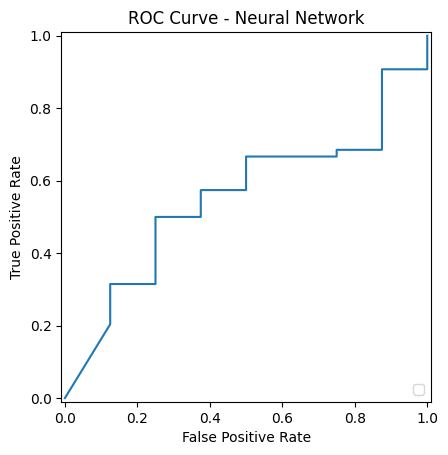

In [90]:
from sklearn.metrics import roc_curve, RocCurveDisplay

def plot_roc(y_true, y_probs, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.ax_.set_title(f"ROC Curve - {model_name}")
    plt.show()

plot_roc(y_true, y_probs, "Neural Network")